<a href="https://colab.research.google.com/github/seojihyuk26/EarthquakePredictor/blob/main/earthquakePredictor_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 로드

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is available


In [2]:
import pandas as pd

In [3]:
import folium
print("folium version:", folium.__version__)

folium version: 0.12.1.post1


In [4]:
from folium import plugins

In [5]:
from keras.layers import LSTM, Dense, Attention
from keras.models import Sequential
import keras

In [6]:
import matplotlib.pyplot as plt

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [1]:
from keras import losses

# 데이터 입력

In [29]:
data = pd.read_csv('https://raw.githubusercontent.com/seojihyuk26/EarthquakePredictor/main/earthquake1900.csv')
data

time  latitude  longitude   depth   mag
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000  6.00
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910  6.37
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000  6.30
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000  6.30
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346  6.00
...                         ...       ...        ...     ...   ...
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000     NaN  6.30
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500     NaN  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200     NaN  7.10
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000     NaN  7.00
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000     NaN  6.40

[13823 rows x 5 columns]

In [30]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       13823 non-null  object 
 1   latitude   13823 non-null  float64
 2   longitude  13823 non-null  float64
 3   depth      13771 non-null  float64
 4   mag        13823 non-null  float64
dtypes: float64(4), object(1)
memory usage: 540.1+ KB
None
(13823, 5)


# 데이터 전처리

In [31]:
data = data.fillna(data.mean())
data

<ipython-input-31-e8d3a8cf2ef0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())


time  latitude  longitude      depth   mag
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000000  6.00
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910000  6.37
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000000  6.30
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000000  6.30
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346000  6.00
...                         ...       ...        ...        ...   ...
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000  56.177293  6.30
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500  56.177293  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200  56.177293  7.10
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000  56.177293  7.00
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000  56.177293  6.40

[13823 rows x 5 columns]

In [35]:
data = data.iloc[::-1]
data

time  latitude  longitude      depth   mag
13822  1901-03-03T07:45:00.000Z   36.0000  -120.5000  56.177293  6.40
13821  1901-12-30T22:34:00.000Z   52.0000  -160.0000  56.177293  7.00
13820  1901-12-31T09:02:30.000Z   51.4500  -171.0200  56.177293  7.10
13819  1902-01-01T05:20:30.000Z   52.3800  -167.4500  56.177293  7.00
13818  1902-11-17T19:50:00.000Z   37.4000  -113.5000  56.177293  6.30
...                         ...       ...        ...        ...   ...
4      2022-12-11T14:31:29.703Z   17.2565  -100.4369  18.346000  6.00
3      2022-12-14T18:40:26.778Z   51.6199   178.6159  73.000000  6.30
2      2022-12-14T18:40:26.902Z   51.6382   178.6190  73.000000  6.30
1      2022-12-20T10:34:24.770Z   40.5250  -124.4230  17.910000  6.37
0      2022-12-28T16:34:20.446Z  -21.2622   171.3631  10.000000  6.00

[13823 rows x 5 columns]

In [41]:
# Convert the time column to datetime
data['time'] = pd.to_datetime(data['time'])

# Calculate the time difference between each time step
data['time'] = data['time'].dt.date.diff().dt.days

data.loc[data.shape[0]-1,"time"] = 0

data

time  latitude  longitude      depth   mag
13822    0.0   36.0000  -120.5000  56.177293  6.40
13821  302.0   52.0000  -160.0000  56.177293  7.00
13820    1.0   51.4500  -171.0200  56.177293  7.10
13819    1.0   52.3800  -167.4500  56.177293  7.00
13818  320.0   37.4000  -113.5000  56.177293  6.30
...      ...       ...        ...        ...   ...
4        7.0   17.2565  -100.4369  18.346000  6.00
3        3.0   51.6199   178.6159  73.000000  6.30
2        0.0   51.6382   178.6190  73.000000  6.30
1        6.0   40.5250  -124.4230  17.910000  6.37
0        8.0  -21.2622   171.3631  10.000000  6.00

[13823 rows x 5 columns]

In [12]:
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append(subset)
    return np.array(dataset)

In [53]:
timesteps = 10
startIndex = 1000
learningIndex = 10000
dataset = seq2dataset(data[startIndex:learningIndex], timesteps)
X_train = dataset[:,0:timesteps]
y_train = dataset[:,timesteps]
print("input data :", X_train, " shape: ", X_train.shape)
print("result :", y_train, " shape: ", y_train.shape)

input data : [[[  11.      -3.048  138.69    35.       6.76 ]
  [   2.      45.625  149.463   15.       6.17 ]
  [   2.      30.579   90.377   15.       6.15 ]
  ...
  [   2.      11.829  -71.459   15.       6.35 ]
  [   2.      36.236   70.674  240.       7.8  ]
  [  14.     -17.732 -172.859   15.       6.2  ]]

 [[   2.      45.625  149.463   15.       6.17 ]
  [   2.      30.579   90.377   15.       6.15 ]
  [   1.     -12.724  166.945   35.       7.02 ]
  ...
  [   2.      36.236   70.674  240.       7.8  ]
  [  14.     -17.732 -172.859   15.       6.2  ]
  [   2.      31.082  119.711   15.       6.62 ]]

 [[   2.      30.579   90.377   15.       6.15 ]
  [   1.     -12.724  166.945   35.       7.02 ]
  [  10.       6.871  -82.484   15.       6.01 ]
  ...
  [  14.     -17.732 -172.859   15.       6.2  ]
  [   2.      31.082  119.711   15.       6.62 ]
  [   7.      35.843  140.294   60.       6.43 ]]

 ...

 [[   2.     -31.791 -179.382  108.3      6.9  ]
  [   5.      24.894   92.

In [14]:
X_train = np.reshape(X_train, (learningIndex-startIndex-timesteps, timesteps, 5))

# 데이터 시각화

In [15]:
def earthquakeVisualizer(data):
  surfaceEnergy = np.multiply(10**(data['mag']*1.5),1/(data['depth']**2+1))
  minSurfaceEnergy = surfaceEnergy.min()

  m = folium.Map(location=[0, 90], zoom_start=2)

  colormap = folium.LinearColormap(
      ['yellow', 'red','black'],
      vmin=data['mag'].min(), vmax=data['mag'].max()
  )
  m.add_child(colormap)

  # 지도 위에 시간 인터렉티브한 바 추가
  timestamps = data['time'].unique()
  features = []
  # minEnergy = 10**(data['mag'].min()*1.5)
  # distanceOfDeepestSixMagReachToOneKM = np.sqrt(data['depth'].max()**2+1)
  for i, row in data.iterrows():
      borderRadius = np.power(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2,1/6)
      # np.sqrt(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2)
      color = colormap(row['mag'])
      feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude'], row['latitude']]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      features.append(feature)
      if row['longitude'] < 0 :
        feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude']+360, row['latitude']]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      features.append(feature)

  time_slider = plugins.TimestampedGeoJson({
      'type': 'FeatureCollection',
      'features': features
  }, period='P10D', add_last_point=True, auto_play=False, loop=False)

  m.add_child(time_slider)

  return m

In [16]:
earthquakeVisualizer(data)

# lstm 모델

In [56]:
# Assume that your input data has shape (batch_size, timesteps, input_dim)
timesteps = 10
input_dim = 5
output_dim = 5
model = Sequential()
model.add(LSTM(8, return_sequences=True, stateful=True,batch_input_shape = (1, timesteps, input_dim)))
# model.add(Attention())
# model.add(LSTM(64))
model.add(Dense(output_dim, activation='softmax'))

In [43]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
def haversine_distance_loss(y_true, y_pred):
    # y_true: (batch_size, 2) 텐서, 지구 위의 2개의 점 좌표
    # y_pred: (batch_size, 1) 텐서, 2개의 점 사이의 거리
    
    # 지구의 지리력(radius)은 6371km로 고정
    earth_radius = 6371.0
    
    # 위도는 (-90, 90)의 범위, 경도는 (-180, 180)의 범위
    lat1, lon1 = tf.unstack(y_true, axis=1)
    lat2, lon2 = tf.unstack(y_pred, axis=1)
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat1 = tf.math.degrees_to_radians(lat1)
    lon1 = tf.math.degrees_to_radians(lon1)
    
    # 위도와 경도 차이 계산
    lat_diff = lat2 - lat1
    lon_diff = lon2 - lon1
    
    # 유클리드 거리 공식 사용
    distance = tf.sqrt((lat_diff ** 2) + (lon_diff ** 2))
    
    # 위도와 경도 차이를 지구 지리력으로 변환
    distance = distance * earth_radius
    
    # 거리의 제곱을 반환
    return distance ** 2


In [ ]:
def custom_loss_function(y_true, y_pred):
    # 위도와 경도는 지구 위의 2개의 점 사이의 거리를 측정하는 커스텀 손실 함수
    distance_loss = haversine_distance_loss([y_true[:, 0], y_true[:, 1]], [y_pred[:, 0], y_pred[:, 1]])
    # 나머지 파라미터는 평균 제곱 오차를 측정하는 함수
    mse_loss = losses.mean_squared_error(y_true[:, 2:], y_pred[:, 2:])
    # 커스텀 손실 함수 결과 반환
    return distance_loss + mse_loss


In [44]:
history = LossHistory() # 손실 이력 객체 생성

history.init()

In [ ]:
model.compile(loss=custom_loss_function, optimizer='adam')

# 모델 훈련

In [57]:
num_epochs = 10

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    

epochs : 0
8990/8990 - 25s - loss: 5994.8052 - 25s/epoch - 3ms/step
epochs : 1
8990/8990 - 25s - loss: 5994.8867 - 25s/epoch - 3ms/step
epochs : 2
8990/8990 - 24s - loss: 5994.6211 - 24s/epoch - 3ms/step
epochs : 3
8990/8990 - 24s - loss: 5993.6045 - 24s/epoch - 3ms/step
epochs : 4
8990/8990 - 24s - loss: 5993.9463 - 24s/epoch - 3ms/step
epochs : 5
8990/8990 - 24s - loss: 5994.0127 - 24s/epoch - 3ms/step
epochs : 6
8990/8990 - 24s - loss: 5994.4790 - 24s/epoch - 3ms/step
epochs : 7
8990/8990 - 24s - loss: 5994.6816 - 24s/epoch - 3ms/step
epochs : 8
8990/8990 - 24s - loss: 5993.6709 - 24s/epoch - 3ms/step
epochs : 9
8990/8990 - 24s - loss: 5993.6587 - 24s/epoch - 3ms/step


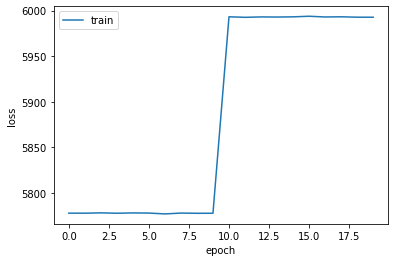

In [55]:
# 6. 학습과정 살펴보기
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [52]:
# 7. 모델 평가하기
scores = model.evaluate(X_train, y_train, batch_size=1)
print("%s: %.2f" %(model.metrics_names[0], scores))
model.reset_states()

9990/9990 [==============================] - 24s 2ms/step - loss: 5780.0181
['loss']
loss: 5780.02
